In [ ]:
!pip install pandas
!pip install numpy
!pip install tqdm
!pip install statistics
!pip install seaborn
!pip install scikit-learn
!pip install xgboost
!pip install optuna

In [6]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from statistics import mean
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report
import pandas as pd
import numpy as np
from collections import defaultdict, deque
from statistics import mean
from tqdm import tqdm
import re


In [ ]:

all_data_filtered = pd.read_csv('./tennis_data_cleaned.csv')

# Assuming all_data_filtered is already prepared and sorted by date
final_data = pd.DataFrame()

# 1. Basic player and diff features
final_data["WINNER_ID"] = all_data_filtered["winner_id"]
final_data["LOSER_ID"] = all_data_filtered["loser_id"]
final_data["ATP_POINT_DIFF"] = all_data_filtered["winner_rank_points"] - all_data_filtered["loser_rank_points"]
final_data["ATP_RANK_DIFF"] = all_data_filtered["winner_rank"] - all_data_filtered["loser_rank"]
final_data["AGE_DIFF"] = all_data_filtered["winner_age"] - all_data_filtered["loser_age"]
final_data["HEIGHT_DIFF"] = all_data_filtered["winner_ht"] - all_data_filtered["loser_ht"]
final_data["BEST_OF"] = all_data_filtered["best_of"]
final_data["DRAW_SIZE"] = all_data_filtered["draw_size"]
# 2. H2H and surface H2H
h2h = defaultdict(lambda: defaultdict(int))
h2h_surf = defaultdict(lambda: defaultdict(lambda: defaultdict(int)))
h2h_diff, h2h_surf_diff = [], []
for w, l, s in tqdm(zip(all_data_filtered.winner_id,
                         all_data_filtered.loser_id,
                         all_data_filtered.surface),
                         total=len(all_data_filtered)):
    h2h_diff.append(h2h[w][l] - h2h[l][w])
    h2h_surf_diff.append(h2h_surf[w][l][s] - h2h_surf[l][w][s])
    h2h[w][l] += 1
    h2h_surf[w][l][s] += 1
final_data['H2H_DIFF'] = h2h_diff
final_data['H2H_SURFACE_DIFF'] = h2h_surf_diff

# 3. Difference in total games for the match with tie-break handling
def diff_n_games(score_str):
    # Extract games won by winner and loser, handling tiebreaks like '7-6(6)'
    total_w, total_l = 0, 0
    for set_score in score_str.split():
        m = re.match(r"(\d+)-(\d+)(?:\(\d+\))?", set_score)
        if m:
            w_games, l_games = int(m.group(1)), int(m.group(2))
            total_w += w_games
            total_l += l_games
    return total_w - total_l

final_data['DIFF_N_GAMES'] = all_data_filtered['score'].apply(diff_n_games)

# 4. Win count differences over last N matches
for k in [3, 5, 10, 25, 50, 100]:
    last_results = defaultdict(lambda: deque(maxlen=k))
    win_diff = []
    for w, l in tqdm(zip(all_data_filtered.winner_id,
                         all_data_filtered.loser_id),
                         total=len(all_data_filtered)):
        win_k = mean(last_results[w]) if last_results[w] else 0
        lose_k = mean(last_results[l]) if last_results[l] else 0
        win_diff.append(win_k - lose_k)
        last_results[w].append(1)
        last_results[l].append(0)
    final_data[f'WIN_LAST_{k}_DIFF'] = win_diff

# 5. Performance metrics difference over last N matches (aces, double faults, etc.)
for k in [3, 5, 10, 20, 50, 100, 200, 300, 2000]:
    last_k = defaultdict(lambda: defaultdict(lambda: deque(maxlen=k)))
    p_metrics = { 'p_ace': [], 'p_df': [], 'p_1stIn': [], 'p_1stWon': [], 'p_2ndWon': [], 'p_bpSaved': [] }
    for row in tqdm(all_data_filtered.itertuples(), total=len(all_data_filtered)):
        w, l = row.winner_id, row.loser_id
        for m in p_metrics:
            pm_w = mean(last_k[w][m]) if last_k[w][m] else 0
            pm_l = mean(last_k[l][m]) if last_k[l][m] else 0
            p_metrics[m].append(pm_w - pm_l)
        def update(pid, ace, df, svpt, first_in, first_won, second_won, bp_saved, bp_faced):
            if svpt and svpt != first_in:
                last_k[pid]['p_ace'].append(100 * ace / svpt)
                last_k[pid]['p_df'].append(100 * df / svpt)
                last_k[pid]['p_1stIn'].append(100 * first_in / svpt)
                last_k[pid]['p_2ndWon'].append(100 * second_won / (svpt - first_in))
            if first_in:
                last_k[pid]['p_1stWon'].append(100 * first_won / first_in)
            if bp_faced:
                last_k[pid]['p_bpSaved'].append(100 * bp_saved / bp_faced)
        update(w, row.w_ace, row.w_df, row.w_svpt, row.w_1stIn, row.w_1stWon, row.w_2ndWon, row.w_bpSaved, row.w_bpFaced)
        update(l, row.l_ace, row.l_df, row.l_svpt, row.l_1stIn, row.l_1stWon, row.l_2ndWon, row.l_bpSaved, row.l_bpFaced)
    for m, values in p_metrics.items():
        final_data[f'{m.upper()}_LAST_{k}_DIFF'] = values

# 6. ELO ratings and gradients
K = 32
elo = defaultdict(lambda: 1500)
elo_surf = defaultdict(lambda: defaultdict(lambda: 1500))
grad_windows = {5:[], 10:[], 20:[], 35:[], 50:[], 100:[], 250:[]}
elodiff_deque = deque()
elo_diff_list, elo_surf_diff_list = [], []
for row in tqdm(all_data_filtered.itertuples(), total=len(all_data_filtered)):
    w, l, s = row.winner_id, row.loser_id, row.surface
    curr_diff = elo[w] - elo[l]
    curr_surf_diff = elo_surf[w][s] - elo_surf[l][s]
    elo_diff_list.append(curr_diff)
    elo_surf_diff_list.append(curr_surf_diff)
    elodiff_deque.append(curr_diff)
    if len(elodiff_deque) > max(grad_windows):
        elodiff_deque.popleft()
    for gw in grad_windows:
        grad_windows[gw].append(curr_diff - list(elodiff_deque)[-gw] if len(elodiff_deque) >= gw else 0)
    exp_w = 1 / (1 + 10 ** ((elo[l] - elo[w]) / 400))
    exp_l = 1 - exp_w
    elo[w] += K * (1 - exp_w)
    elo[l] += K * (0 - exp_l)
    exp_w_s = 1 / (1 + 10 ** ((elo_surf[l][s] - elo_surf[w][s]) / 400))
    elo_surf[w][s] += K * (1 - exp_w_s)
    elo_surf[l][s] += K * (0 - exp_w_s)
final_data['ELO_DIFF'] = elo_diff_list
final_data['ELO_SURFACE_DIFF'] = elo_surf_diff_list
for gw, vals in grad_windows.items():
    final_data[f'ELO_GRAD_{gw}_DIFF'] = vals

# 7. Result (target) - Set the result to 1 for the winner, 0 for the loser
final_data['RESULT'] = 1

print("All features engineered. Shape:", final_data.shape)


In [1]:
import pandas as pd
import re
from collections import defaultdict, deque
from statistics import mean
from tqdm import tqdm

# 0. Load data
all_data_filtered = pd.read_csv('./tennis_data_cleaned.csv')

# 1. Create empty DataFrame
data_test = pd.DataFrame()

# 2. Basic player and diff features
data_test["WINNER_ID"] = all_data_filtered["winner_id"]
data_test["LOSER_ID"] = all_data_filtered["loser_id"]
data_test["ATP_POINT_DIFF"] = all_data_filtered["winner_rank_points"] - all_data_filtered["loser_rank_points"]
data_test["ATP_RANK_DIFF"] = all_data_filtered["winner_rank"] - all_data_filtered["loser_rank"]
data_test["AGE_DIFF"] = all_data_filtered["winner_age"] - all_data_filtered["loser_age"]
data_test["HEIGHT_DIFF"] = all_data_filtered["winner_ht"] - all_data_filtered["loser_ht"]
data_test["BEST_OF"] = all_data_filtered["best_of"]
data_test["DRAW_SIZE"] = all_data_filtered["draw_size"]

# 3. H2H and surface H2H
h2h = defaultdict(lambda: defaultdict(int))
h2h_surf = defaultdict(lambda: defaultdict(lambda: defaultdict(int)))
h2h_diff, h2h_surf_diff = [], []

for w, l, s in tqdm(zip(all_data_filtered.winner_id,
                        all_data_filtered.loser_id,
                        all_data_filtered.surface),
                        total=len(all_data_filtered)):
    h2h_diff.append(h2h[w][l] - h2h[l][w])
    h2h_surf_diff.append(h2h_surf[w][l][s] - h2h_surf[l][w][s])
    h2h[w][l] += 1
    h2h_surf[w][l][s] += 1

data_test['H2H_DIFF'] = h2h_diff
data_test['H2H_SURFACE_DIFF'] = h2h_surf_diff

# 4. Difference in total games for the match with tie-break handling
def diff_n_games(score_str):
    total_w, total_l = 0, 0
    for set_score in str(score_str).split():
        m = re.match(r"(\d+)-(\d+)(?:\(\d+\))?", set_score)
        if m:
            w_games, l_games = int(m.group(1)), int(m.group(2))
            total_w += w_games
            total_l += l_games
    return total_w - total_l

data_test['DIFF_N_GAMES'] = all_data_filtered['score'].apply(diff_n_games)

# 5. Win count differences over last N matches
for k in [3, 5, 10, 25, 50, 100]:
    last_results = defaultdict(lambda: deque(maxlen=k))
    win_diff = []
    for w, l in tqdm(zip(all_data_filtered.winner_id,
                         all_data_filtered.loser_id),
                         total=len(all_data_filtered)):
        win_k = mean(last_results[w]) if last_results[w] else 0
        lose_k = mean(last_results[l]) if last_results[l] else 0
        win_diff.append(win_k - lose_k)
        last_results[w].append(1)
        last_results[l].append(0)
    data_test[f'WIN_LAST_{k}_DIFF'] = win_diff

# 6. Performance metrics difference over last N matches
for k in [3, 5, 10, 20, 50, 100, 200, 300, 2000]:
    last_k = defaultdict(lambda: defaultdict(lambda: deque(maxlen=k)))
    p_metrics = { 'p_ace': [], 'p_df': [], 'p_1stIn': [], 'p_1stWon': [], 'p_2ndWon': [], 'p_bpSaved': [] }
    
    for row in tqdm(all_data_filtered.itertuples(), total=len(all_data_filtered)):
        w, l = row.winner_id, row.loser_id

        for m in p_metrics:
            pm_w = mean(last_k[w][m]) if last_k[w][m] else 0
            pm_l = mean(last_k[l][m]) if last_k[l][m] else 0
            p_metrics[m].append(pm_w - pm_l)

        def update(pid, ace, df, svpt, first_in, first_won, second_won, bp_saved, bp_faced):
            if svpt and svpt != first_in:
                last_k[pid]['p_ace'].append(100 * ace / svpt)
                last_k[pid]['p_df'].append(100 * df / svpt)
                last_k[pid]['p_1stIn'].append(100 * first_in / svpt)
                last_k[pid]['p_2ndWon'].append(100 * second_won / (svpt - first_in))
            if first_in:
                last_k[pid]['p_1stWon'].append(100 * first_won / first_in)
            if bp_faced:
                last_k[pid]['p_bpSaved'].append(100 * bp_saved / bp_faced)

        update(w, row.w_ace, row.w_df, row.w_svpt, row.w_1stIn, row.w_1stWon, row.w_2ndWon, row.w_bpSaved, row.w_bpFaced)
        update(l, row.l_ace, row.l_df, row.l_svpt, row.l_1stIn, row.l_1stWon, row.l_2ndWon, row.l_bpSaved, row.l_bpFaced)

    for m, values in p_metrics.items():
        data_test[f'{m.upper()}_LAST_{k}_DIFF'] = values

# 7. ELO ratings and gradients (AFTER the match)
K = 32
elo = defaultdict(lambda: 1500)
elo_surf = defaultdict(lambda: defaultdict(lambda: 1500))
grad_windows = {5: [], 10: [], 20: [], 35: [], 50: [], 100: [], 250: []}
elodiff_deque = deque()

elo_diff_list = []
elo_surf_diff_list = []

for row in tqdm(all_data_filtered.itertuples(), total=len(all_data_filtered)):
    w, l, s = row.winner_id, row.loser_id, row.surface

    # Expected scores
    exp_w = 1 / (1 + 10 ** ((elo[l] - elo[w]) / 400))
    exp_l = 1 - exp_w

    exp_w_s = 1 / (1 + 10 ** ((elo_surf[l][s] - elo_surf[w][s]) / 400))

    # Update ELOs
    elo[w] += K * (1 - exp_w)
    elo[l] += K * (0 - exp_l)

    elo_surf[w][s] += K * (1 - exp_w_s)
    elo_surf[l][s] += K * (0 - exp_w_s)

    # After update, record differences
    curr_diff = elo[w] - elo[l]
    curr_surf_diff = elo_surf[w][s] - elo_surf[l][s]

    elo_diff_list.append(curr_diff)
    elo_surf_diff_list.append(curr_surf_diff)

    # Gradients
    elodiff_deque.append(curr_diff)
    if len(elodiff_deque) > max(grad_windows):
        elodiff_deque.popleft()
    for gw in grad_windows:
        grad_windows[gw].append(curr_diff - list(elodiff_deque)[-gw] if len(elodiff_deque) >= gw else 0)

# Assign to data_test
data_test['ELO_DIFF'] = elo_diff_list
data_test['ELO_SURFACE_DIFF'] = elo_surf_diff_list
for gw, vals in grad_windows.items():
    data_test[f'ELO_GRAD_{gw}_DIFF'] = vals

# 8. Result (target)
data_test['RESULT'] = 1

print("✅ All features engineered. Shape:", data_test.shape)


100%|██████████| 95375/95375 [00:01<00:00, 78955.69it/s]

✅ All features engineered. Shape: (95375, 81)


In [2]:
final_data = data_test.copy()

In [3]:

# Assume final_data has all your features (ELO_DIFF, ATP_POINT_DIFF, etc.) + RESULT=1
#final_data = pd.read_csv("./final.csv")
# 1) Positive class (winners)
df_pos = final_data.copy()

# 2) Negative class (losers): flip every numeric diff, label 0
df_neg = final_data.copy()
diff_cols = [c for c in final_data.columns if c not in ['WINNER_ID','LOSER_ID','RESULT']]
df_neg[diff_cols] = -df_neg[diff_cols]
df_neg['RESULT'] = 0

# 3) Combine and shuffle
df_bal = pd.concat([df_pos, df_neg], ignore_index=True)
df_bal = df_bal.sample(frac=1, random_state=42).reset_index(drop=True)


In [4]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split



for feature in ['ELO_DIFF', 'ELO_SURFACE_DIFF']:
    X = df_bal[[feature]].values
    y = df_bal['RESULT'].values.astype(int)

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )

    clf = DecisionTreeClassifier(max_depth=4, random_state=42)
    clf.fit(X_train, y_train)

    print(f"{feature}:")
    print("  Train Accuracy:", accuracy_score(y_train, clf.predict(X_train)))
    print("  Test  Accuracy:", accuracy_score(y_test,  clf.predict(X_test)), "\n")


ELO_DIFF:
  Train Accuracy: 0.7365858453473132
  Test  Accuracy: 0.7372739187418087 

ELO_SURFACE_DIFF:
  Train Accuracy: 0.6676343381389253
  Test  Accuracy: 0.6668152031454784 



Train Accuracy: 0.7608191349934469
Test  Accuracy: 0.7557011795543905

Classification Report on Test Set:

              precision    recall  f1-score   support

           0       0.75      0.76      0.76     19075
           1       0.76      0.75      0.76     19075

    accuracy                           0.76     38150
   macro avg       0.76      0.76      0.76     38150
weighted avg       0.76      0.76      0.76     38150



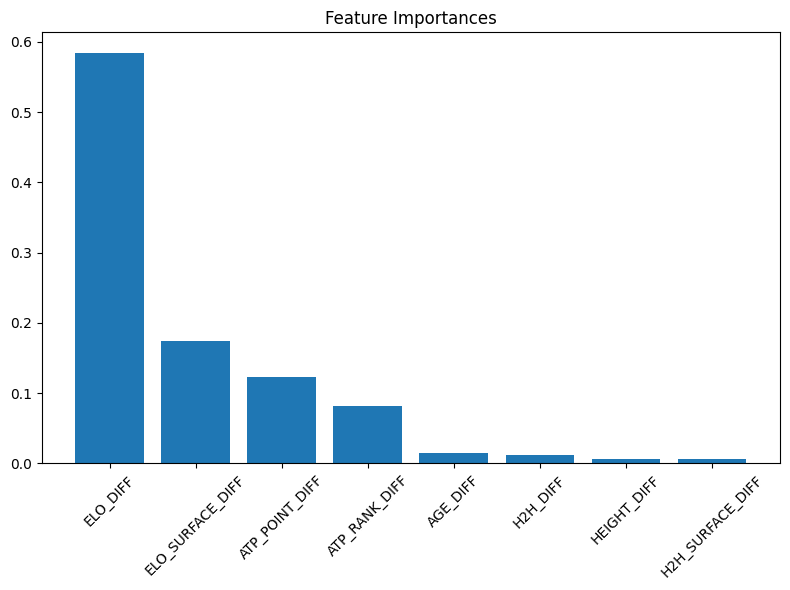

In [7]:
# 1. Pick multiple features
features = [
    'ELO_DIFF', 
    'ELO_SURFACE_DIFF', 
    'ATP_POINT_DIFF', 
    'ATP_RANK_DIFF', 
    'AGE_DIFF', 
    'HEIGHT_DIFF', 
    'H2H_DIFF', 
    'H2H_SURFACE_DIFF'
]

# 2. Prepare data
X = df_bal[features].values
y = df_bal['RESULT'].values.astype(int)

# 3. Split into train and test
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# 4. Train Random Forest
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

rf = RandomForestClassifier(
    n_estimators=200,
    max_depth=9,
    random_state=42
)

rf.fit(X_train, y_train)

# 5. Evaluate
y_pred_train = rf.predict(X_train)
y_pred_test = rf.predict(X_test)

print("Train Accuracy:", accuracy_score(y_train, y_pred_train))
print("Test  Accuracy:", accuracy_score(y_test, y_pred_test))
print("\nClassification Report on Test Set:\n")
print(classification_report(y_test, y_pred_test))

# 6. Feature Importances
import matplotlib.pyplot as plt
import numpy as np

importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(8,6))
plt.title("Feature Importances")
plt.bar(range(len(features)), importances[indices], align="center")
plt.xticks(range(len(features)), [features[i] for i in indices], rotation=45)
plt.tight_layout()
plt.show()


/Users/theo/Desktop/PERSO/scripts/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [00:53:04] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Train Accuracy: 0.7709436435124508
Test  Accuracy: 0.761651376146789

Classification Report on Test Set:

              precision    recall  f1-score   support

           0       0.76      0.77      0.76     19075
           1       0.76      0.76      0.76     19075

    accuracy                           0.76     38150
   macro avg       0.76      0.76      0.76     38150
weighted avg       0.76      0.76      0.76     38150



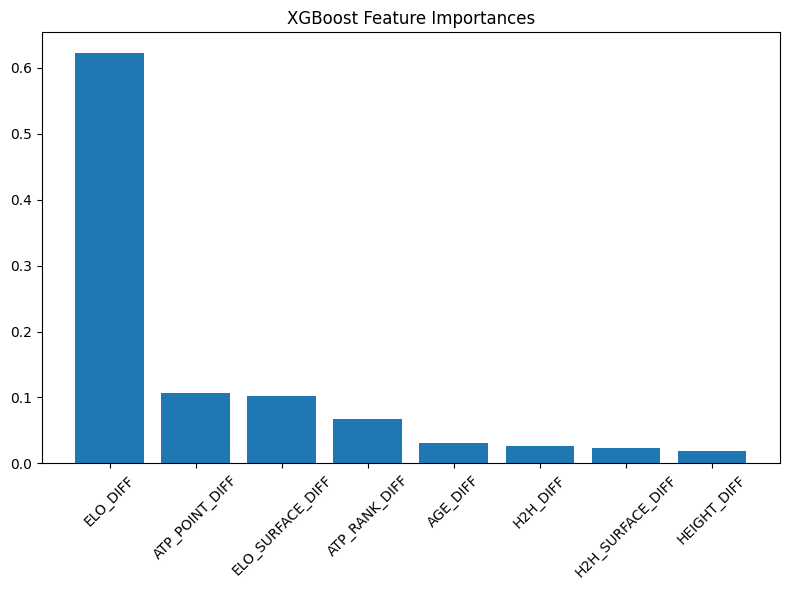

In [ ]:
# 1. Import
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split

# 2. Features
features = [
    'ELO_DIFF', 
    'ELO_SURFACE_DIFF', 
    'ATP_POINT_DIFF', 
    'ATP_RANK_DIFF', 
    'AGE_DIFF', 
    'HEIGHT_DIFF', 
    'H2H_DIFF', 
    'H2H_SURFACE_DIFF',
    
]

X = df_bal[features].values
y = df_bal['RESULT'].values.astype(int)

# 3. Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# 4. Train XGBoost
xgb = XGBClassifier(
    n_estimators=200,      # more trees
    max_depth=9,           # deeper trees
    learning_rate=0.05,    # smaller steps
    subsample=0.8,         # bagging
    colsample_bytree=0.8,  # feature sampling
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss'
)

xgb.fit(X_train, y_train)

# 5. Evaluate
y_pred_train = xgb.predict(X_train)
y_pred_test = xgb.predict(X_test)

print("Train Accuracy:", accuracy_score(y_train, y_pred_train))
print("Test  Accuracy:", accuracy_score(y_test, y_pred_test))
print("\nClassification Report on Test Set:\n")
print(classification_report(y_test, y_pred_test))

# 6. Feature Importances
import matplotlib.pyplot as plt
import numpy as np

importances = xgb.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(8,6))
plt.title("XGBoost Feature Importances")
plt.bar(range(len(features)), importances[indices], align="center")
plt.xticks(range(len(features)), [features[i] for i in indices], rotation=45)
plt.tight_layout()
plt.show()


/Users/theo/Desktop/PERSO/scripts/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:04:19] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Train Accuracy: 1.0
Test  Accuracy: 1.0

Classification Report on Test Set:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     19075
           1       1.00      1.00      1.00     19075

    accuracy                           1.00     38150
   macro avg       1.00      1.00      1.00     38150
weighted avg       1.00      1.00      1.00     38150



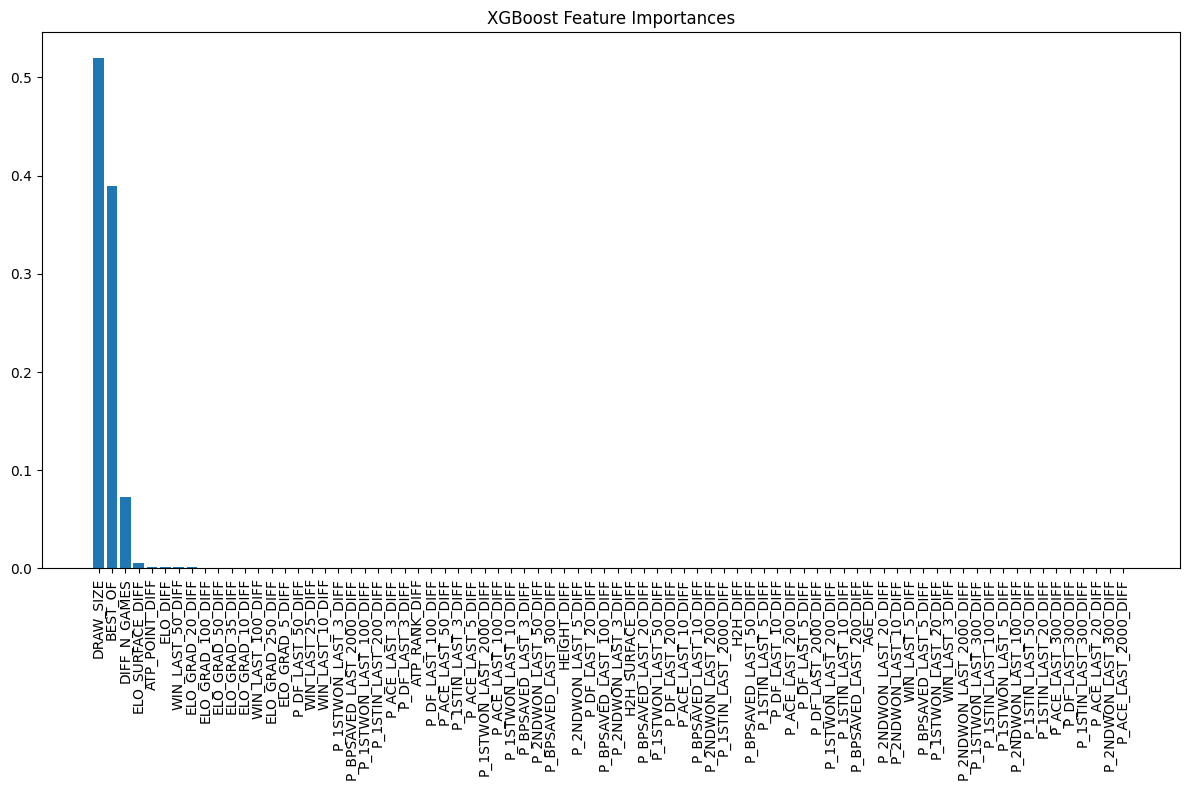

In [13]:
# 1. Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split

# 2. Feature list (all you sent)
features = [
    'ATP_POINT_DIFF', 'ATP_RANK_DIFF', 'AGE_DIFF', 'HEIGHT_DIFF', 'BEST_OF', 'DRAW_SIZE',
    'H2H_DIFF', 'H2H_SURFACE_DIFF', 'DIFF_N_GAMES',
    'WIN_LAST_3_DIFF', 'WIN_LAST_5_DIFF', 'WIN_LAST_10_DIFF', 'WIN_LAST_25_DIFF', 
    'WIN_LAST_50_DIFF', 'WIN_LAST_100_DIFF',
    'P_ACE_LAST_3_DIFF', 'P_DF_LAST_3_DIFF', 'P_1STIN_LAST_3_DIFF', 'P_1STWON_LAST_3_DIFF', 
    'P_2NDWON_LAST_3_DIFF', 'P_BPSAVED_LAST_3_DIFF',
    'P_ACE_LAST_5_DIFF', 'P_DF_LAST_5_DIFF', 'P_1STIN_LAST_5_DIFF', 'P_1STWON_LAST_5_DIFF', 
    'P_2NDWON_LAST_5_DIFF', 'P_BPSAVED_LAST_5_DIFF',
    'P_ACE_LAST_10_DIFF', 'P_DF_LAST_10_DIFF', 'P_1STIN_LAST_10_DIFF', 'P_1STWON_LAST_10_DIFF', 
    'P_2NDWON_LAST_10_DIFF', 'P_BPSAVED_LAST_10_DIFF',
    'P_ACE_LAST_20_DIFF', 'P_DF_LAST_20_DIFF', 'P_1STIN_LAST_20_DIFF', 'P_1STWON_LAST_20_DIFF', 
    'P_2NDWON_LAST_20_DIFF', 'P_BPSAVED_LAST_20_DIFF',
    'P_ACE_LAST_50_DIFF', 'P_DF_LAST_50_DIFF', 'P_1STIN_LAST_50_DIFF', 'P_1STWON_LAST_50_DIFF', 
    'P_2NDWON_LAST_50_DIFF', 'P_BPSAVED_LAST_50_DIFF',
    'P_ACE_LAST_100_DIFF', 'P_DF_LAST_100_DIFF', 'P_1STIN_LAST_100_DIFF', 'P_1STWON_LAST_100_DIFF', 
    'P_2NDWON_LAST_100_DIFF', 'P_BPSAVED_LAST_100_DIFF',
    'P_ACE_LAST_200_DIFF', 'P_DF_LAST_200_DIFF', 'P_1STIN_LAST_200_DIFF', 'P_1STWON_LAST_200_DIFF', 
    'P_2NDWON_LAST_200_DIFF', 'P_BPSAVED_LAST_200_DIFF',
    'P_ACE_LAST_300_DIFF', 'P_DF_LAST_300_DIFF', 'P_1STIN_LAST_300_DIFF', 'P_1STWON_LAST_300_DIFF', 
    'P_2NDWON_LAST_300_DIFF', 'P_BPSAVED_LAST_300_DIFF',
    'P_ACE_LAST_2000_DIFF', 'P_DF_LAST_2000_DIFF', 'P_1STIN_LAST_2000_DIFF', 'P_1STWON_LAST_2000_DIFF', 
    'P_2NDWON_LAST_2000_DIFF', 'P_BPSAVED_LAST_2000_DIFF',
    'ELO_DIFF', 'ELO_SURFACE_DIFF',
    'ELO_GRAD_5_DIFF', 'ELO_GRAD_10_DIFF', 'ELO_GRAD_20_DIFF', 'ELO_GRAD_35_DIFF', 
    'ELO_GRAD_50_DIFF', 'ELO_GRAD_100_DIFF', 'ELO_GRAD_250_DIFF'
]

# 3. Prepare data
X = df_bal[features].values
y = df_bal['RESULT'].values.astype(int)

# 4. Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# 5. Model
xgb = XGBClassifier(
    n_estimators=500,      # more trees
    max_depth=8,           # deeper trees
    learning_rate=0.03,    # smaller steps
    subsample=0.9,         # random subsample
    colsample_bytree=0.8,  # random feature sampling
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss'
)

# 6. Fit
xgb.fit(X_train, y_train)

# 7. Predict
y_pred_train = xgb.predict(X_train)
y_pred_test = xgb.predict(X_test)

# 8. Report
print("Train Accuracy:", accuracy_score(y_train, y_pred_train))
print("Test  Accuracy:", accuracy_score(y_test, y_pred_test))
print("\nClassification Report on Test Set:\n")
print(classification_report(y_test, y_pred_test))

# 9. Feature importance plot
importances = xgb.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(12, 8))
plt.title("XGBoost Feature Importances")
plt.bar(range(len(features)), importances[indices], align="center")
plt.xticks(range(len(features)), [features[i] for i in indices], rotation=90)
plt.tight_layout()
plt.show()


In [24]:
import numpy as np
from xgboost import XGBClassifier

# Function to retrieve player stats given an ID
def get_player_stats(player_id, df):
    # Retrieve stats for the player from the dataframe using player ID
    player_data = df[df['WINNER_ID'] == player_id].iloc[0]  # Assuming 'PLAYER_1_ID' is the player identifier column
    return player_data

# Function to calculate feature differences
def calculate_diffs(player1_id, player2_id, df, features):
    # Get stats for Player 1 and Player 2
    player1 = get_player_stats(player1_id, df)
    player2 = get_player_stats(player2_id, df)
    
    # Calculate feature differences (Player1 - Player2)
    feature_diff = {}
    for feature in features:
        feature_diff[feature + '_DIFF'] = player1[feature] - player2[feature]
    
    return feature_diff

# Predict the match outcome using the trained XGBoost model
def predict_match(player1_id, player2_id, df, model, features):
    # Calculate the differences between Player 1 and Player 2
    feature_diff = calculate_diffs(player1_id, player2_id, df, features)
    
    # Convert the feature differences into an array (input format for the model)
    X_new = np.array([list(feature_diff.values())]).reshape(1, -1)
    
    # Make the prediction using the model
    y_pred = model.predict(X_new)
    y_pred_proba = model.predict_proba(X_new)  # Get the probabilities of prediction
    
    # Output the result
    print("Winner:", "Player 1" if y_pred[0] == 1 else "Player 2")
    print("Winning probability for Player 1:", y_pred_proba[0][1])

# Example usage
player1_id = 111575.0  # Replace with the Player 1 ID
player2_id = 126205.0  # Replace with the Player 2 ID

# The features used for training
features = [
    'ELO_DIFF', 
    'ELO_SURFACE_DIFF', 
    'ATP_POINT_DIFF', 
    'ATP_RANK_DIFF', 
    'AGE_DIFF', 
    'HEIGHT_DIFF', 
    'H2H_DIFF', 
    'H2H_SURFACE_DIFF',
]

# Predict the match result
predict_match(player1_id, player2_id, df_bal, xgb, features)


ValueError: Feature shape mismatch, expected: 78, got 8